In [3]:
import numpy as np
import numpy
np.random.seed(0)
import matplotlib.pyplot as plt
from numba import jit
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import time
%matplotlib inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
#File containing 30000 data points (2 dimensional)
f = open("X_l.txt")
X_population = []
X_temp = []

for line in f:
    line = line.strip().split(" ")
    X_values = []
    X_values.append(float(line[0]))
    X_values.append(float(line[1]))
    
    X_temp.append(X_values)
X_population = np.array(X_temp) #Losing precision

indices = np.arange(len(X_population))
rnd_indices = np.random.choice(indices, size=3000)
X = X_population[rnd_indices]
print(X.shape, type(X))

(3000, 2) <class 'numpy.ndarray'>


[1.3857680202242968, 0.8812113977016466, 0.5005044536594112, 0.4671118185529497, 0.4351299377063594, 0.4015556105757843, 0.38027976613408193, 0.35565493026237416, 0.3361426980937073]


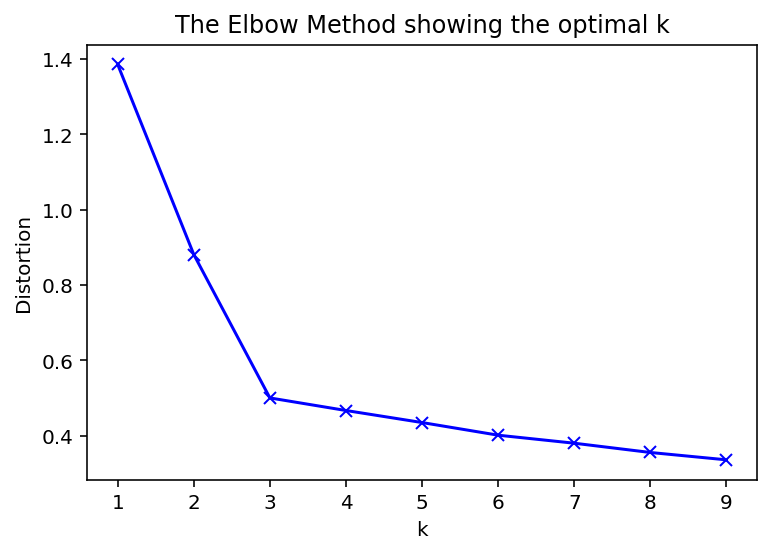

In [5]:
#Determining the value of k in kmeans

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
#print(distortions)

print(distortions)
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

k = 0
while(distortions[k] - distortions[k+1] > 0.1):
    k = k+1
k = k+1

In [5]:
# # Visualize the data
# fig, ax = plt.subplots(figsize=(4,4))
# ax.scatter(X[:,0], X[:,1], alpha=0.5)
# ax.set_xlabel('$x_1$')
# ax.set_ylabel('$x_2$');

In [6]:
#Defining centers
centers = [[1, 1], [-1, -1], [1, -1]] #for DBSCAN
centroids = np.asarray([[1.0, 1.0], [-1.0, -1.0], [1.0, -1.0]]) #KMeans

In [7]:
#@jit
def get_distances(centroid, points):
    """Returns the distance the centroid is from each data point in points."""
    return np.linalg.norm(points - centroid, axis=1)

In [8]:
def MyKMeans(maxiter):
    # Loop for the maximum number of iterations
    for i in range(maxiter):
    
        # Assign all points to the nearest centroid
        for j, c in enumerate(centroids):
            distances[:, j] = get_distances(c, X)
        
        # Determine class membership of each point by picking the closest centroid
        classes = np.argmin(distances, axis=1)
    
        # Update centroid location using the newly assigned data point classes
        for c in range(k):
            centroids[c] = np.mean(X[classes == c], 0)
            
    return centroids, classes

In [9]:
#KMeans

maxiter = 50
# Initialize the vectors in which we will store the assigned classes of each data point and the calculated distances from each centroid
classes = np.zeros(X.shape[0], dtype=np.float64)
distances = np.zeros([X.shape[0], k], dtype=np.float64)

start_kmeans = time.time()
centroids, classes = MyKMeans(maxiter)
end_kmeans = time.time()
#print(centroids)

#Time taken in seconds
time_kmeans = end_kmeans - start_kmeans
print("Elapsed (after compilation) = %s" % time_kmeans)

Elapsed (after compilation) = 0.3169131278991699


In [13]:
#Validating
kmeans = KMeans(n_clusters=3)
kmeans = kmeans.fit(X)
centroids_orig = kmeans.cluster_centers_
#print(centroids)

i = 0
#Assuming 100% accuracy
accuracy_kmeans = 1
while(centroids[i] not in centroids_orig and accuracy_kmeans != 0):
    accuracy_kmeans = 0 #Accuracy not 100%

In [14]:
#@jit
def MyDBSCAN(D, eps, MinPts):
 
    # -1 - Indicates a noise point; 0 - Means the point hasn't been considered yet.
    # Initially all labels are 0.    
    labels = [0]*len(D)

    # C is the ID of the current cluster.    
    C = 0
    
    for P in range(0, len(D)):
    
        if not (labels[P] == 0):
            continue
        
        # Find all of P's neighboring points.
        NeighborPts = regionQuery(D, P, eps)
        
        if len(NeighborPts) < MinPts:
            labels[P] = -1
        else: 
            C += 1
            growCluster(D, labels, P, NeighborPts, C, eps, MinPts)
    
    # All data has been clustered!
    return labels


In [15]:
#@jit
def growCluster(D, labels, P, NeighborPts, C, eps, MinPts):
   
    #`C` - The label for this new cluster.  
    # Assign the cluster label to the seed point.
    labels[P] = C
    
    i = 0
    while i < len(NeighborPts):    
        
        # Get the next point from the queue.        
        Pn = NeighborPts[i]
       
        if labels[Pn] == -1:
            labels[Pn] = C
        elif labels[Pn] == 0:
            labels[Pn] = C

            PnNeighborPts = regionQuery(D, Pn, eps)

            if len(PnNeighborPts) >= MinPts:
                NeighborPts = NeighborPts + PnNeighborPts

        i += 1        


In [16]:
#@jit
def regionQuery(D, P, eps):

    neighbors = []
    
    # For each point in the dataset...
    for Pn in range(0, len(D)):
        
        # If the distance is below the threshold, add it to the neighbors list.
        if numpy.linalg.norm(D[P] - D[Pn]) < eps:
            neighbors.append(Pn)
            
    return neighbors


In [17]:
#DBSCAN
X = StandardScaler().fit_transform(X)
my_labels = MyDBSCAN(X, eps=0.3, MinPts=10)

start_dbscan = time.time()
X = StandardScaler().fit_transform(X)
my_labels = MyDBSCAN(X, eps=0.3, MinPts=10)
end_dbscan = time.time()

time_dbscan = end_dbscan - start_dbscan
print("Elapsed (after compilation) = %s" % (time_dbscan))


db = DBSCAN(eps=0.3, min_samples=10).fit(X)
skl_labels = db.labels_

# Scikit learn uses -1 to for NOISE, and starts cluster labeling at 0. I start numbering at 1, so increment the skl cluster numbers by 1.
for i in range(0, len(skl_labels)):
    if not skl_labels[i] == -1:
        skl_labels[i] += 1

num_disagree = 0
# Go through each label and make sure they match (print the labels if they # don't)
count = 0
for i in range(0, len(skl_labels)):
    if not skl_labels[i] == my_labels[i]:
        print('Scikit learn:', skl_labels[i], 'mine:', my_labels[i])
        num_disagree += 1
    else:
        count = count +1 

if num_disagree == 0:
    print('PASS - All labels match!')
else:
    print('FAIL -', num_disagree, 'labels don\'t match.')

accuracy_dbscan = float(count)/len(skl_labels)
print(accuracy_dbscan)

NameError: name 'end' is not defined

In [29]:
X= X_population

if(accuracy_dbscan > accuracy_kmeans):
    X = StandardScaler().fit_transform(X)
    my_labels = MyDBSCAN(X, eps=0.3, MinPts=10)
else:
    classes = np.zeros(X.shape[0], dtype=np.float64)
    distances = np.zeros([X.shape[0], k], dtype=np.float64)
    centroids, classes = MyKMeans(maxiter)